## TOC:
* [Setup](#first-bullet)
* [Image Compresion & Reconstruction](#second-bullet)
* [Feature Detection](#third-bullet)
* [Base Segmentation Techniques](#forth-bullet)
* [TLDR](#last-bullet)

## Setup <a class="anchor" id="first-bullet"></a>

In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA


In [4]:
def read_img_rgb(img_name):
    img_rgb = cv2.cvtColor(cv2.imread(f'../L1/{img_name}'), cv2.COLOR_BGR2RGB)
    return img_rgb

def read_img_grayscale(img_name):
    img_g = cv2.cvtColor(cv2.imread(f'../L1/{img_name}'), cv2.COLOR_BGR2GRAY)
    return img_g

## Image Compresion & Reconstruction <a class="anchor" id="second-bullet"></a>



### Introduction
Image compression reduces file size by removing redundancy in data representation, allowing efficient storage and transmission. There are two main types of compression:
* **Lossy Compression**: Reduces file size by discarding some information  
    * e.g.: JPEG, removing of requencies in FFT spectral space, dimensionality reduction (PCA)
* **Lossless Compression**: Preserves all data for perfect reconstruction
    * e.g.: PNG

Compressing and reconstructing an image using JPEG (lossy) and PNG (lossless) formats.

In [7]:
import cv2

# Load the image
img_name = 'fruits_5.webp'
image = cv2.imread(f'../L1/{img_name}')
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB for proper display with Matplotlib

# JPEG Compression
jpeg_compression_params = [int(cv2.IMWRITE_JPEG_QUALITY), 50]  # 50% quality
cv2.imwrite("compressed_image.jpg", image, jpeg_compression_params)
compressed_jpeg = cv2.imread("compressed_image.jpg")
compressed_jpeg_rgb = cv2.cvtColor(compressed_jpeg, cv2.COLOR_BGR2RGB)

# PNG Compression
png_compression_params = [int(cv2.IMWRITE_PNG_COMPRESSION), 9]  # Max compression for PNG
cv2.imwrite("compressed_image.png", image, png_compression_params)
compressed_png = cv2.imread("compressed_image.png")
compressed_png_rgb = cv2.cvtColor(compressed_png, cv2.COLOR_BGR2RGB)


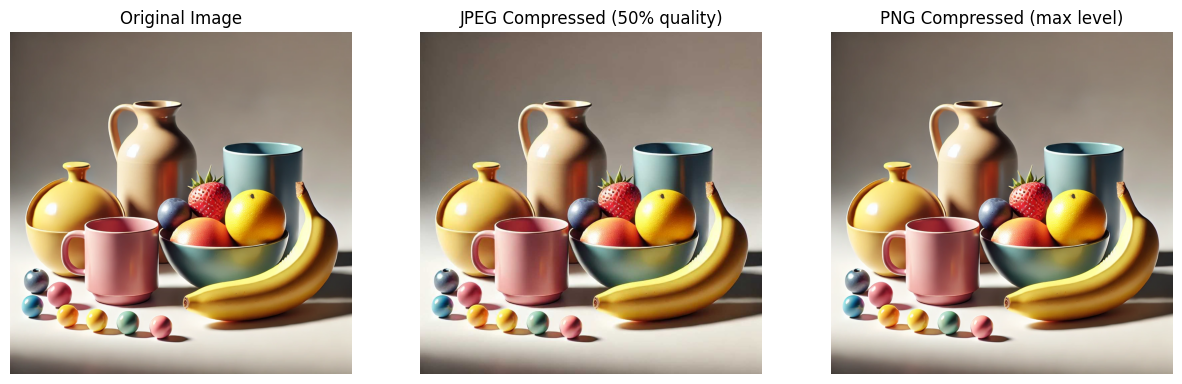

In [8]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].imshow(image_rgb)
axes[0].set_title("Original Image")
axes[0].axis("off")

axes[1].imshow(compressed_jpeg_rgb)
axes[1].set_title("JPEG Compressed (50% quality)")
axes[1].axis("off")

axes[2].imshow(compressed_png_rgb)
axes[2].set_title("PNG Compressed (max level)")
axes[2].axis("off")

plt.show()

Image Compression and Reconstruction with PCA

### Introduction
PCA is a dimensionality reduction technique that identifies the principal components (directions of maximum variance) in data. For image compression, we:
1. Flatten the image data into a 2D matrix.
2. Apply PCA to reduce the number of components, retaining only the most significant features.
3. Reconstruct the image using these principal components, achieving a compressed version with reduced quality but lower data size.

### Mathematical Steps
Let $X$ be the original data matrix (e.g., grayscale image pixels):
1. **Mean Centering**: Subtract the mean from $X$ to center the data.
2. **Covariance Matrix**: Compute the covariance matrix of the centered data.
3. **Eigen Decomposition**: Calculate eigenvalues and eigenvectors of the covariance matrix.
4. **Dimensionality Reduction**: Select top $k$ eigenvectors (principal components) corresponding to the highest eigenvalues.
5. **Reconstruction**: Approximate the original data using the selected components.

Below, we demonstrate PCA compression and reconstruction on an example grayscale image.


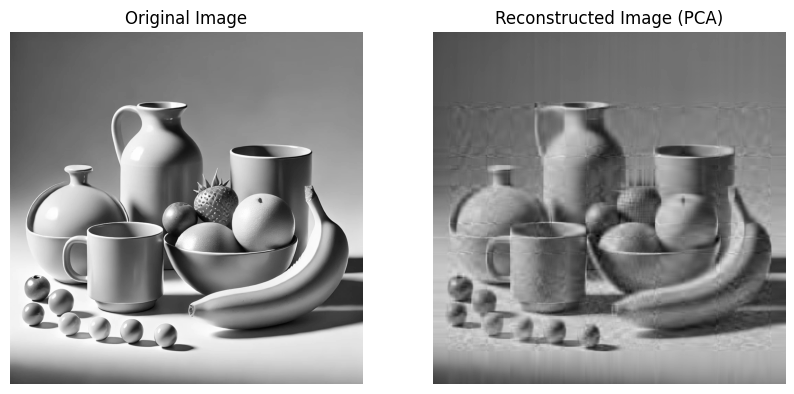

Original size: 1048576, Compressed size: 29696


In [16]:
img_name = 'fruits_5.webp'
image = read_img_grayscale(img_name)

# Normalize pixel values
image_normalized = image / 255.0

# Step 1: Flatten the image into 2D
original_shape = image_normalized.shape
flat_image = image_normalized.reshape(-1, original_shape[1])

# Step 2: Apply PCA
# Set the number of components to retain 90% variance
pca = PCA(0.95)  # Adjust variance as needed (e.g., 0.95 for 95% retained variance)
compressed = pca.fit_transform(flat_image)

# Step 3: Reconstruct the image
reconstructed = pca.inverse_transform(compressed)
reconstructed_image = reconstructed.reshape(original_shape)

# Step 4: Display the original and reconstructed images
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(image_normalized, cmap='gray')
axes[0].set_title("Original Image")
axes[0].axis("off")

axes[1].imshow(reconstructed_image, cmap='gray')
axes[1].set_title("Reconstructed Image (PCA)")
axes[1].axis("off")
plt.show()

# Optional: Show the amount of data reduction
print(f"Original size: {flat_image.size}, Compressed size: {compressed.size}")

## Feature Detection <a class="anchor" id="third-bullet"></a>

### Definitions
* **Feature Detection**: Identifying unique points or regions in an image, like corners and edges, for image analysis.
    * Feature detection is the process of identifying important points or structures within an image. \
    These features can be points, edges, or regions that have distinctive properties compared to their surroundings.
    * Eg: edges with Sobel or Canny, corners with Harris Corner Detection, Blosb/Regions with Laplacian of Gausian (LoG)
* **Feature Descriptors**: Representing features in a form that describes their appearance (e.g., SIFT, ORB).
    * Once features are detected, the next step is to represent them in a way that enables matching or comparison. \
    Feature descriptors are unique representations or "signatures" of the detected features. They provide additional information \
    about each feature that can be used to distinguish it from others. \
    A good descriptor should be:
        * Invariant to transformations: It should remain recognizable even if the image undergoes rotation, scaling, or changes in illumination.
        * Compact and robust: It should represent features with minimal data while capturing essential details.
    * Eg: SIFT, ORB, SURF, LBP
* **Feature Matching**: Identifying matching features between images, useful in tasks like object recognition and image stitching.
    * Comparing features from different images to find correspondences. This is essential for applications like image stitching or 3D reconstruction.

Data Structure of a Feature Descriptor
* **SIFT (Scale-Invariant Feature Transform):** \
SIFT divides the area around a feature point into a grid (e.g., 4x4). For each cell in the grid, it calculates a histogram of gradient orientations, \
representing how pixel intensities change within that cell. These histograms are concatenated into a single vector (e.g., a 128-dimensional vector for a 4x4 grid with 8 orientation bins). \
This vector captures the pattern of intensity changes in a rotation and scale-invariant way.

* **ORB (Oriented FAST and Rotated BRIEF):** \
ORB uses a binary descriptor based on the BRIEF descriptor, which compares pairs of pixel intensities within the feature region. \
If the intensity of one pixel in a pair is greater than the other, a binary "1" is recorded; otherwise, a "0" is recorded. \
These binary comparisons produce a compact and efficient descriptor that is also invariant to rotation.

* **LBP (Local Binary Patterns):** \
LBP describes textures by encoding the pattern of pixel intensity changes around a feature. \
For each pixel in the feature neighborhood, LBP compares it with its neighbors in a clockwise order, \
assigning binary values based on whether the neighboring pixel is brighter or darker than the center pixel. The result is a binary pattern (often represented as a decimal or hexadecimal number), \
capturing local texture information.

In [19]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def calculate_lbp(image):
    # Convert image to grayscale if it is not already
    if len(image.shape) > 2:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Define the LBP output image
    lbp_image = np.zeros_like(image, dtype=np.uint8)

    # Iterate over each pixel in the image (excluding border pixels)
    for i in range(1, image.shape[0] - 1):
        for j in range(1, image.shape[1] - 1):
            center = image[i, j]
            binary_pattern = []

            # Compare neighboring pixels in clockwise order
            binary_pattern.append(1 if image[i - 1, j - 1] >= center else 0)  # top-left
            binary_pattern.append(1 if image[i - 1, j] >= center else 0)      # top
            binary_pattern.append(1 if image[i - 1, j + 1] >= center else 0)  # top-right
            binary_pattern.append(1 if image[i, j + 1] >= center else 0)      # right
            binary_pattern.append(1 if image[i + 1, j + 1] >= center else 0)  # bottom-right
            binary_pattern.append(1 if image[i + 1, j] >= center else 0)      # bottom
            binary_pattern.append(1 if image[i + 1, j - 1] >= center else 0)  # bottom-left
            binary_pattern.append(1 if image[i, j - 1] >= center else 0)      # left

            # Convert binary pattern to a decimal value
            binary_string = ''.join(str(bit) for bit in binary_pattern)
            lbp_value = int(binary_string, 2)

            # Set the LBP value for the pixel in the LBP image
            lbp_image[i, j] = lbp_value

    return lbp_image

# Load a sample grayscale image
image = read_img_grayscale(img_name)

# Calculate LBP
lbp_image = calculate_lbp(image)

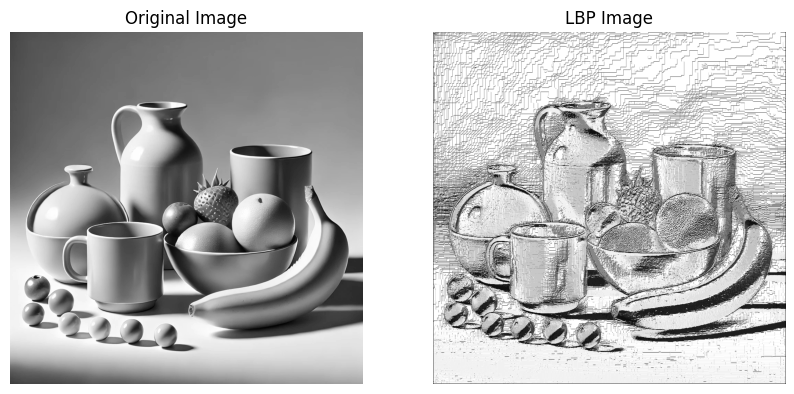

In [20]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(image, cmap='gray')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("LBP Image")
plt.imshow(lbp_image, cmap='gray')
plt.axis('off')
plt.show()

OpenCV has an efficient implementation for calculating Local Binary Patterns (LBP) through the cv2.face.LBPHFaceRecognizer class, mainly used for face recognition. \
However, if you want a more general LBP calculation (not specific to face recognition), you can use other libraries like scikit-image for a straightforward implementation.

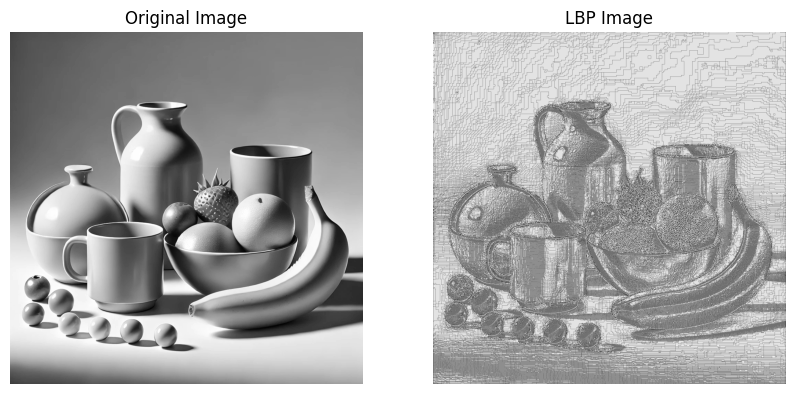

In [24]:
from skimage import feature

# Parameters for LBP
# The scikit-image library provides a more flexible and general implementation for LBP, allowing you to specify the radius and number of points used in the LBP calculation.
radius = 1  # Radius of the circular neighborhood
n_points = 8 * radius  # Number of points in the neighborhood

# Calculate LBP
lbp_image = feature.local_binary_pattern(image, n_points, radius, method='uniform')

# Display the original and LBP images
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(image, cmap='gray')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("LBP Image")
plt.imshow(lbp_image, cmap='gray')
plt.axis('off')
plt.show()

## Base Segmentation Techniques <a class="anchor" id="forth-bullet"></a>

### K-Means Clustering
K-means is an unsupervised method that groups pixels into clusters based on intensity or color similarity. 

### Thresholding & Otsu’s Method
Otsu’s thresholding minimizes intra-class variance between foreground and background for automatic threshold selection.

### Watershed Algorithm
A gradient-based segmentation where regions are treated as "basins." Local minima form “markers,” and the algorithm floods basins until they meet. 
1. **Marker Assignment**: Identify sure foreground and background regions.
2. **Distance Transformation**: Calculate distances from markers to edges.
3. **Watershed Segmentation**: Segment using the watershed flooding approach.

In [105]:
kmeans_image = cv2.imread("../L1/green_landscape.webp")
otsu_image = cv2.imread("../L2/obj2.jpg", cv2.IMREAD_GRAYSCALE)
watershed_image = cv2.imread("../L1/arm1.jpg")

In [87]:
kmeans_image_rgb = cv2.cvtColor(kmeans_image, cv2.COLOR_BGR2RGB)

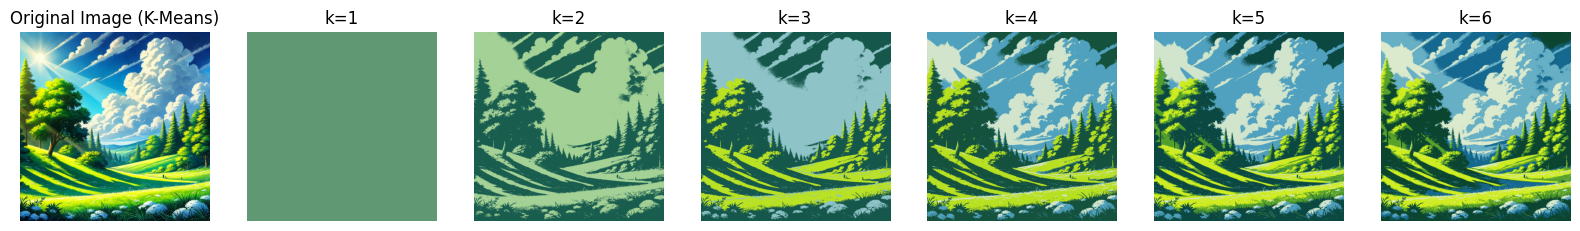

In [52]:
fig, axes = plt.subplots(1, 7, figsize=(20, 5))
axes[0].imshow(kmeans_image_rgb)
axes[0].set_title("Original Image (K-Means)")
axes[0].axis("off")

for i, k in enumerate([1, 2, 3, 4, 5, 6], 1):
    # Reshape and apply k-means

    # Reshape to 2D array of pixels with 3 color channels
    pixels = kmeans_image.reshape((-1, 3))

    # unit8 values to float as is a requirement of the k-means method of OpenCV
    pixels = np.float32(pixels)

    # Iteration termination criteria
    # Tuple: ( type, max_iter, epsilon 
    # cv.TERM_CRITERIA_EPS — stop the algorithm iteration if specified accuracy, epsilon, is reached.
    # cv.TERM_CRITERIA_MAX_ITER — stop the algorithm after the specified number of iterations, max_iter.
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.2)

    # cv2.kmeans(samples, nclusters, _, criteria, attempts, flags), used for color clustering
    # cv2.KMEANS_RANDOM_CENTER specify how initial centers are taken
    _, labels, centers = cv2.kmeans(pixels, k, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)

    # convert back into uint8
    centers = np.uint8(centers)

    # stack
    segmented_image = centers[labels.flatten()].reshape(kmeans_image.shape)
    segmented_image_rgb = cv2.cvtColor(segmented_image, cv2.COLOR_BGR2RGB)

    # Plot segmented image
    axes[i].imshow(segmented_image_rgb)
    axes[i].set_title(f"k={k}")
    axes[i].axis("off")

plt.show()

In [72]:
# Otsu's Thresholding
_, otsu_thresh = cv2.threshold(otsu_image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

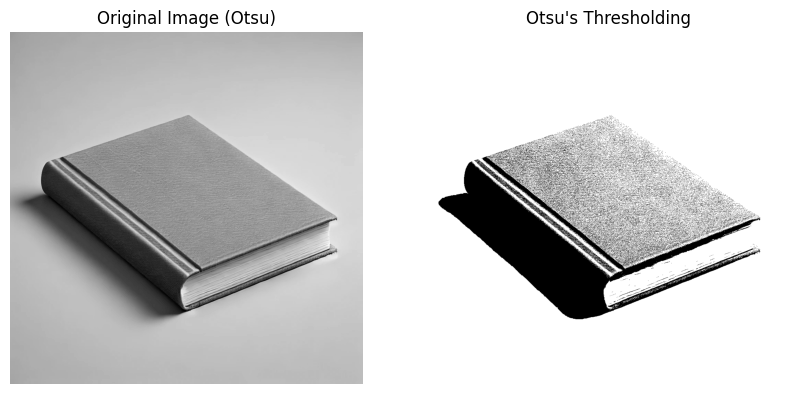

In [73]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(otsu_image, cmap="gray")
ax[0].set_title("Original Image (Otsu)")
ax[0].axis("off")

ax[1].imshow(otsu_thresh, cmap="gray")
ax[1].set_title("Otsu's Thresholding")
ax[1].axis("off")

plt.show()

# Watershed Algorithm - Step-by-Step Explanation

The Watershed algorithm is a powerful image segmentation technique that "floods" an image from specific markers to \
separate overlapping or touching objects. It is especially useful for segmenting complex, cluttered images with clear intensity gradients.

## Step-by-Step Explanation of the Watershed Algorithm

### 1. Convert Image to Grayscale (if needed)
If the image is in color, it is first converted to grayscale, as intensity gradients are more straightforward in a single channel.

### 2. Thresholding to Create a Binary Image
The algorithm typically applies a thresholding method, such as **Otsu’s Thresholding** or binary thresholding, to separate objects from the background.

- **Formula for Binary Thresholding**:
  $$
  T(x, y) = 
  \begin{cases} 
   255 & \text{if } I(x, y) > \text{Threshold} \\ 
   0 & \text{if } I(x, y) \leq \text{Threshold}
  \end{cases}
  $$

This binary image helps identify areas of high intensity (foreground) and low intensity (background).

### 3. Distance Transform for Foreground Marker Extraction
The algorithm applies a **Distance Transform** to the binary image to identify foreground markers (specific points within objects).

- **Distance Transform** calculates the distance of each pixel from the nearest background pixel.

- **Formula for Distance Transform**:
  - For each foreground pixel $(x, y)$, its distance transform value $ D(x, y) $ is given by:
    $$
    D(x, y) = \min \{ \text{distance}(x, y, b) \mid b \in \text{background pixels} \}
    $$

Pixels farther from the background get higher values. \
Thresholding this transformed image (e.g., at 70% of the maximum distance) identifies sure foreground areas, ensuring they’re entirely within objects.

### 4. Identify Background and Unknown Regions
After identifying foreground markers, the background is defined as regions with low-intensity values or areas distant from objects. \
Any region not labeled as foreground or background is marked as "unknown," where the algorithm will attempt to determine boundaries.

### 5. Marker Labeling for Segmentation Regions
**Connected Components** is used to label different foreground objects, giving each distinct connected component a unique label.

The marker matrix has unique integer labels for each identified region. \
For example, pixels belonging to object 1 may get label "1," object 2 gets label "2," and the background is "0".

### 6. Applying Watershed Transformation (Flooding Process)
The core of the Watershed algorithm is based on treating the intensity image as a topographic surface \
where pixel intensities represent heights:

- **Higher Intensity** (lighter pixels): Peaks or ridges.
- **Lower Intensity** (darker pixels): Valleys or basins.

Starting from each marker, the algorithm "floods" each basin, expanding outwards. As flooding continues, neighboring regions eventually meet.

- **Flooding Process**:
  - Flooding starts from the foreground markers.
  - When two regions meet, the algorithm marks their boundary as a watershed line.
  - This prevents any overlap between objects, separating them distinctly.

### 7. Resulting Watershed Lines (Boundaries)
The algorithm completes when all pixels are assigned to a region or a boundary (watershed line).

In practice, OpenCV’s `cv2.watershed()` assigns watershed boundary pixels the value "-1," allowing easy visualization of these boundaries (e.g., marking them in red for distinction).

---

This step-by-step outline of the Watershed algorithm shows how it leverages intensity gradients to separate touching objects, making it ideal for images with overlapping regions, like medical imaging or complex natural scenes.

In [106]:
# Watershed Segmentation
gray_watershed = cv2.cvtColor(watershed_image, cv2.COLOR_BGR2GRAY)

# 1. Apply thresholding to get binary imag
_, binary = cv2.threshold(gray_watershed, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

# 2. Distance Transform and Foreground Detection
dist_transform = cv2.distanceTransform(binary, cv2.DIST_L2, 5)
_, sure_fg = cv2.threshold(dist_transform, 0.7 * dist_transform.max(), 255, 0)
sure_fg = np.uint8(sure_fg)

# 3. Define markers for Watershed
unknown = cv2.subtract(binary, sure_fg)
_, markers = cv2.connectedComponents(sure_fg)
markers += 1
markers[unknown == 255] = 0
markers = cv2.watershed(cv2.cvtColor(watershed_image, cv2.COLOR_BGR2RGB), markers)
watershed_result = watershed_image.copy()
watershed_result[markers == -1] = [0, 0, 255]  # Mark boundaries in red

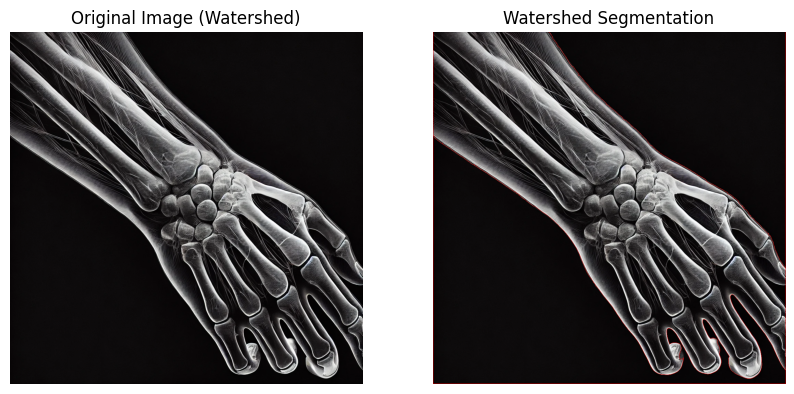

: 

In [107]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(cv2.cvtColor(watershed_image, cv2.COLOR_BGR2RGB))
ax[0].set_title("Original Image (Watershed)")
ax[0].axis("off")

ax[1].imshow(cv2.cvtColor(watershed_result, cv2.COLOR_BGR2RGB))
ax[1].set_title("Watershed Segmentation")
ax[1].axis("off")

plt.show()